### Importazione librerie

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import product

In [50]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [51]:
data_inizio = '2021-02-01'
data_fine = '2021-07-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


In [52]:
# Parametri fissi
liquidità_iniziale = 0  # Liquidità iniziale in euro
bitcoin_iniziali = 0.02478146   # Quantità iniziale di Bitcoin posseduti
prezzo_medio_acquisti = 15000  # Prezzo medio ponderato degli acquisti
prezzo_medio_vendite_iniziale = 20000   # Prezzo medio ponderato delle vendite

# Parametri variabili
soglia_sopportabile = 0.1  # Percentuale di discesa sopportabile (es. 20%)
vendita_rispetto_inizio = True  # Se vendere rispetto ai BTC iniziali
paracadute_variabile = False
sopportazione_variabile = False
pct_paracadute = 0.2  # Percentuale di paracadute (ad es. 5%)
# Con A=1 e B=1 la mappatura torna a essere l'identità
A_v = 8
B_v = 0.15
acquisto_attivo = False
acquista_pure = False
A_a = 8
B_a = 0.15

# Parametri calcolati
# Calcolo la base di riferimento per il prezzo (prezzo medio vendite + pct_paracadute)
prezzo_paracadute = prezzo_medio_vendite_iniziale * (1 + pct_paracadute)

In [53]:
def grafico(dati, prezzo_paracadute):
    # Creazione del grafico
    plt.figure(figsize=(14, 7))
    plt.plot(dati["Timestamp"], dati["Price"], color="blue", label="Prezzo Bitcoin")

    # Linea verde per il prezzo medio di acquisto
    plt.axhline(y=prezzo_medio_acquisti, color="green", linestyle="--", linewidth=1.5, label="Prezzo Medio Pesato Acquisto Iniziale")

    # Linea rossa per il prezzo medio di vendita
    plt.axhline(y=prezzo_medio_vendite_iniziale, color="red", linestyle="--", linewidth=1.5, label="Prezzo Medio Pesato Vendita Iniziale")

    # Linea rossa per il prezzo medio di vendita
    plt.axhline(y=prezzo_paracadute, color="purple", linestyle="--", linewidth=1.5, label="Prezzo Paracadute")

    # Dettagli del grafico
    plt.title("Andamento del Prezzo di Bitcoin con soglie di Acquisto, Vendita e Paracadute")
    plt.xlabel("Data")
    plt.ylabel("Prezzo in Euro")
    plt.legend()
    plt.grid()

    # Mostra il grafico
    plt.show()

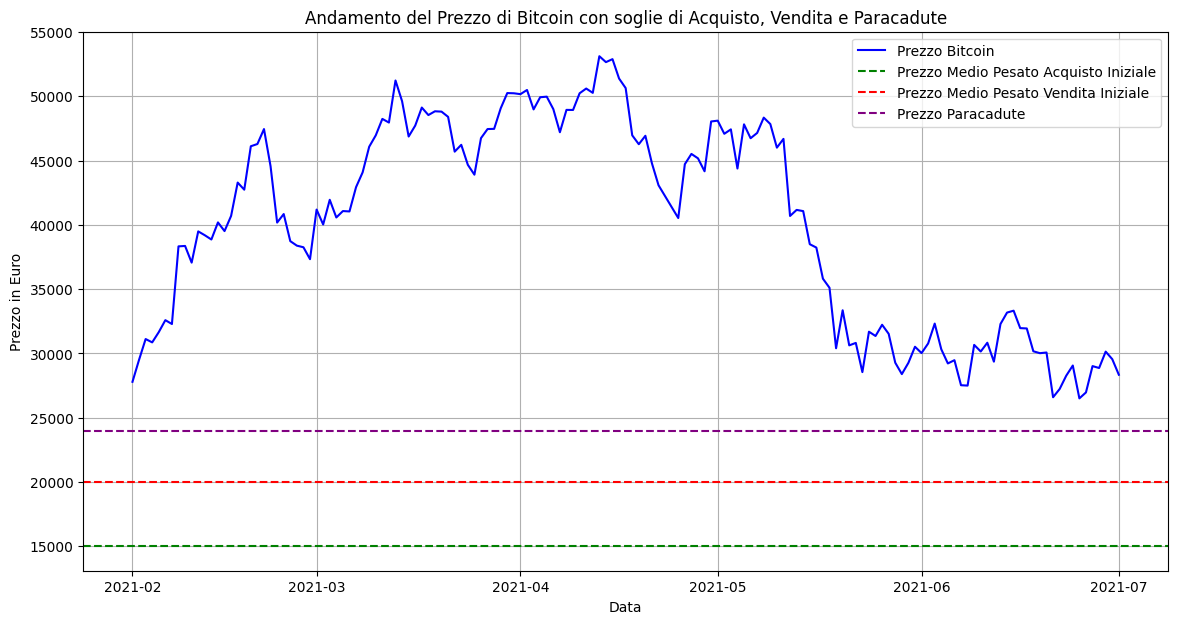

In [54]:
grafico(dati, prezzo_paracadute)

### Strategia

In [55]:
def calcola_max_drawdown_relativo_prezzo(prezzi, prezzi_paracadute):
    """
    Calcola il massimo drawdown dei prezzi, cioè la massima discesa percentuale del prezzo
    rispetto al massimo precedente, ma relativamente al prezzo paracadute

    Parameters:
    - prezzi (pd.Series or list): Serie temporale dei prezzi.

    Returns:
    - max_drawdown (float): Il massimo drawdown percentuale sui prezzi.
    - drawdown_serie (pd.Series): La serie temporale del drawdown percentuale giorno per giorno.
    """
    # Trasformo i prezzi in una Serie pandas se non lo è già
    prezzi = pd.Series(prezzi)
    
    # Calcola i massimi cumulativi dei prezzi fino a ogni punto
    max_prezzi_cumulativi = prezzi.cummax()
    
    # Calcola il drawdown percentuale relativo
    drawdown_serie = (max_prezzi_cumulativi - prezzi) / (max_prezzi_cumulativi - prezzi_paracadute)
    
    # Trova il massimo drawdown
    max_drawdown = drawdown_serie.max()
    
    # Ritorna il max drawdown
    return max_drawdown

def mappatura_discesa_vendita(percentuale_discesa_relativa, A, B):
    return percentuale_discesa_relativa ** A / (B + (1 - B) * percentuale_discesa_relativa ** A)

In [56]:
def strategia_vendita(dati, liquidità_iniziale, bitcoin_iniziali, prezzo_medio_vendite_iniziale, soglia_sopportabile, vendita_rispetto_inizio, paracadute_variabile, sopportazione_variabile, pct_paracadute, A_v, B_v, acquisto_attivo, acquista_pure, A_a, B_a, stampa_grafico=False):

    prezzo_paracadute = prezzo_medio_vendite_iniziale * (1 + pct_paracadute)

    # Variabili iniziali
    btc_posseduti = bitcoin_iniziali
    liquidità = liquidità_iniziale
    massimo_prezzo_raggiunto = dati['Price'].iloc[0] # Per tenere traccia del massimo raggiunto
    massimo_precedente = dati['Price'].iloc[0]

    prezzi_paracadute = [prezzo_paracadute]

    # DataFrame per registrare le transazioni giornaliere
    transazioni = []

    # Itera sulle righe del DataFrame (supponendo ordinato per data)
    for i in range(1, len(dati)):
        # Aggiorna il massimo prezzo raggiunto
        prezzo_attuale = dati["Price"].iloc[i]

        if max(massimo_prezzo_raggiunto, prezzo_attuale) > massimo_prezzo_raggiunto:
            massimo_precedente = massimo_prezzo_raggiunto
            massimo_prezzo_raggiunto = max(massimo_prezzo_raggiunto, prezzo_attuale)
            if paracadute_variabile:
                prezzo_paracadute = prezzo_paracadute * massimo_prezzo_raggiunto / massimo_precedente #prezzo_attuale / rapporto_prezzo_e_paracadute
                if stampa_grafico:
                    grafico(dati.iloc[:i+1], prezzo_paracadute)

            prezzi_paracadute.append(prezzo_paracadute)

            if sopportazione_variabile:
                max_drawdown_relativo_prezzo = calcola_max_drawdown_relativo_prezzo(dati["Price"].iloc[:i+1], prezzi_paracadute)
                # Cambio la soglia sopportabile solo se il max drawdown relativo che c'è stato in passato è maggiore della soglia sopportabile attuale
                if max_drawdown_relativo_prezzo > soglia_sopportabile:
                    soglia_sopportabile = max_drawdown_relativo_prezzo
        else:
            prezzi_paracadute.append(prezzo_paracadute)

        azione = "-"
        btc_da_vendere = 0
        liquidità_da_spendere = 0
        liquidità_guadagnata = 0
        pct_btc_venduta_attuali = '-'
        pct_btc_venduta_iniziali = '-'
        pct_liquidità_spesa = '-'

        # Calcola la percentuale attuale di discesa rispetto alla base di riferimento
        percentuale_discesa_relativa = (massimo_prezzo_raggiunto - prezzo_attuale) / (massimo_prezzo_raggiunto - prezzo_paracadute)
        if percentuale_discesa_relativa > 1:
            percentuale_discesa_relativa = 1
        
        # Controlla se il prezzo attuale è in discesa rispetto al prezzo di ieri
        prezzo_ieri = dati["Price"].iloc[i - 1]
        prezzo_in_discesa = prezzo_attuale < prezzo_ieri
        variazione_prezzo = (prezzo_attuale - prezzo_ieri) / prezzo_ieri

        # Condizione di vendita
        if percentuale_discesa_relativa > soglia_sopportabile and prezzo_in_discesa:
            # Calcola la percentuale di BTC da vendere
            percentuale_da_vendere = mappatura_discesa_vendita(percentuale_discesa_relativa, A_v, B_v) if mappatura_discesa_vendita(percentuale_discesa_relativa, A_v, B_v) <= 1 else 1
            
            if vendita_rispetto_inizio:
                # Calcola la quantità di BTC da vendere rispetto ai BTC iniziali
                btc_da_vendere = bitcoin_iniziali * percentuale_da_vendere
            else:
                # Calcola la quantità di BTC da vendere rispetto ai BTC attualmente posseduti
                btc_da_vendere = btc_posseduti * percentuale_da_vendere

            # Verifica di non vendere più BTC di quanti ne possieda
            if btc_da_vendere > btc_posseduti:
                btc_da_vendere = btc_posseduti

            if btc_posseduti > 0:
                # Effettua la vendita
                liquidità_guadagnata = btc_da_vendere * prezzo_attuale
                liquidità += liquidità_guadagnata
                btc_posseduti_prima = btc_posseduti
                btc_posseduti -= btc_da_vendere
                azione = "Vendita"

                # Calcola le percentuali di BTC venduta
                pct_btc_venduta_attuali = (btc_da_vendere / btc_posseduti_prima)
                pct_btc_venduta_iniziali = (btc_da_vendere / bitcoin_iniziali)

        if acquisto_attivo:
            # Condizione di acquisto
            if not prezzo_in_discesa:
                # Calcolo la percentuale di BTC da comprare
                percentuale_da_comprare = mappatura_discesa_vendita(percentuale_discesa_relativa, A_a, B_a) if mappatura_discesa_vendita(percentuale_discesa_relativa, A_a, B_a) <= 1 else 0

                # Calcolo la quantità di liquidità da spendere in base alla liquidità attuale
                liquidità_da_spendere = liquidità * percentuale_da_comprare

                # Verifico di non usare più liquidità di quella che ho
                if liquidità_da_spendere > liquidità:
                    # Controllo se posso spendere tutto quello che ho anche se non è sufficiente o se non spendere niente in questi casi
                    if acquista_pure:
                        liquidità_da_spendere = liquidità
                    else:
                        liquidità_da_spendere = 0

                if liquidità_da_spendere > 0:
                    # Effettuo l'acquisto
                    liquidità_prima = liquidità
                    liquidità -= liquidità_da_spendere
                    btc_guadagnati = liquidità_da_spendere / prezzo_attuale
                    btc_posseduti += btc_guadagnati
                    azione = "Acquisto"

                    # Calcolo le percentuali di liquidità spesa
                    pct_liquidità_spesa = (liquidità_da_spendere / liquidità_prima)

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + (btc_posseduti * prezzo_attuale)

        # Registra i dati nel dataframe delle transazioni
        transazioni.append({
            "Timestamp": dati["Timestamp"].iloc[i],
            "prezzo": prezzo_attuale,
            "max_prezzo": massimo_prezzo_raggiunto,
            "prezzo_paracadute": prezzo_paracadute,
            "soglia_sopportabile": soglia_sopportabile,
            "variazione % prezzo": variazione_prezzo,  # Convertito in percentuale
            "% discesa relativa": percentuale_discesa_relativa,
            "azione": azione,
            "quantità BTC venduta": btc_da_vendere,
            "quantità liquidità spesa": liquidità_da_spendere,
            "% BTC venduta attuali": pct_btc_venduta_attuali,
            "% BTC venduta iniziali": pct_btc_venduta_iniziali,
            "% liquidità spesa": pct_liquidità_spesa,
            "liquidità guadagnata": liquidità_guadagnata,
            "liquidità": liquidità,
            "bitcoin": btc_posseduti,
            "valore_totale_portafoglio": valore_totale_portafoglio
        })

    # Crea un DataFrame dalle transazioni
    df_transazioni = pd.DataFrame(transazioni)

    # Mostra le prime righe del DataFrame delle transazioni
    return df_transazioni, prezzi_paracadute

In [57]:
df_transazioni, prezzi_paracadute = strategia_vendita(dati, liquidità_iniziale, bitcoin_iniziali, prezzo_medio_vendite_iniziale, soglia_sopportabile, vendita_rispetto_inizio, paracadute_variabile, sopportazione_variabile, pct_paracadute, A_v, B_v, acquisto_attivo, acquista_pure, A_a, B_a)

In [58]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / (liquidità_iniziale + bitcoin_iniziali * dati['Price'].iloc[0])

np.float64(1.1693830075771636)

In [59]:
df_transazioni[:]

,Timestamp,prezzo,max_prezzo,prezzo_paracadute,soglia_sopportabile,variazione % prezzo,% discesa relativa,azione,quantità BTC venduta,quantità liquidità spesa,% BTC venduta attuali,% BTC venduta iniziali,% liquidità spesa,liquidità guadagnata,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-02,29501.521484,29501.521484,24000.0,0.1,0.061565,0.000000,-,0.0,0,-,-,-,0.0,0.000000,0.024781,731.090775
1,2021-02-03,31119.447266,31119.447266,24000.0,0.1,0.054842,0.000000,-,0.0,0,-,-,-,0.0,0.000000,0.024781,771.185338
2,2021-02-04,30859.554688,31119.447266,24000.0,0.1,-0.008351,0.036505,-,0.0,0,-,-,-,0.0,0.000000,0.024781,764.744820
3,2021-02-05,31658.248047,31658.248047,24000.0,0.1,0.025882,0.000000,-,0.0,0,-,-,-,0.0,0.000000,0.024781,784.537608
4,2021-02-06,32588.472656,32588.472656,24000.0,0.1,0.029383,0.000000,-,0.0,0,-,-,-,0.0,0.000000,0.024781,807.589932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-06-27,29013.742188,53123.628906,24000.0,0.1,0.075958,0.827846,-,0.0,0,-,-,-,0.0,805.343783,0.000000,805.343783
146,2021-06-28,28866.302734,53123.628906,24000.0,0.1,-0.005082,0.832909,-,0.0,0,-,-,-,0.0,805.343783,0.000000,805.343783
147,2021-06-29,30139.980469,53123.628906,24000.0,0.1,0.044123,0.789175,-,0.0,0,-,-,-,0.0,805.343783,0.000000,805.343783
148,2021-06-30,29555.054688,53123.628906,24000.0,0.1,-0.019407,0.809260,-,0.0,0,-,-,-,0.0,805.343783,0.000000,805.343783


In [60]:
# Supponiamo che df_transazioni sia già creato e contenga tutte le colonne richieste
# Gestione NaN per sicurezza
df_transazioni['quantità BTC venduta'] = pd.to_numeric(df_transazioni['quantità BTC venduta'], errors='coerce')
df_transazioni['quantità liquidità spesa'] = pd.to_numeric(df_transazioni.get('quantità liquidità spesa', 0), errors='coerce')

# Filtra solo le transazioni di vendita e acquisto
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

# Calcolo della dimensione dei punti per le vendite e gli acquisti
max_quantita_vendita = vendite['quantità BTC venduta'].max()
max_quantita_acquisto = acquisti['quantità liquidità spesa'].max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Applica la funzione di dimensione per ogni punto vendita e acquisto
dimensioni_vendite = vendite['quantità BTC venduta'].apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
dimensioni_acquisti = acquisti['quantità liquidità spesa'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

# Funzione per formattare in modo sicuro i prezzi e altri valori
def safe_format(value, precision=2):
    return f"{float(value):.{precision}f}" if pd.api.types.is_numeric_dtype(type(value)) and pd.notna(value) else "None"

# Creazione del grafico dei prezzi con le vendite e acquisti
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=df_transazioni['Timestamp'],
    y=df_transazioni['prezzo'],
    mode='lines',
    name='Prezzi Bitcoin',
    line=dict(color='blue', width=2),
    hoverinfo='x+y'
))

# Scatter plot per le vendite con dimensione in base alla quantità BTC venduta
fig.add_trace(go.Scatter(
    x=vendite['Timestamp'],
    y=vendite['prezzo'],
    mode='markers',
    name='Vendite',
    marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Variazione % prezzo: {safe_format(var_prezzo * 100, 2)} %<br>% discesa relativa: {round(desc * 100, 2) or 'None'} %<br>Quantità BTC venduta: {safe_format(qta, 4)}<br>% BTC venduta attuali: {safe_format(pct_attuali * 100, 2)} %<br>% BTC venduta iniziali: {safe_format(pct_iniziali * 100, 2)} %<br>Liquidità guadagnata: {safe_format(liquid_guad, 2)} €<br>Quantità liquidità spesa: {safe_format(qls, 2)}<br>Liquidità totale: {safe_format(liquid_tot, 2)} €<br>BTC rimanenti: {safe_format(btc_posseduti, 4)}<br>Valore totale portafoglio: {safe_format(valore_port, 2)} €"
        for timestamp, prezzo, var_prezzo, desc, qta, pct_attuali, pct_iniziali, liquid_guad, qls, liquid_tot, btc_posseduti, valore_port in zip(
            vendite['Timestamp'],
            vendite['prezzo'],
            vendite['variazione % prezzo'],
            vendite['% discesa relativa'],
            vendite['quantità BTC venduta'],
            vendite['% BTC venduta attuali'],
            vendite['% BTC venduta iniziali'],
            vendite['liquidità guadagnata'],
            vendite['quantità liquidità spesa'],
            vendite['liquidità'],
            vendite['bitcoin'],
            vendite['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Scatter plot per gli acquisti con dimensione in base alla quantità liquidità spesa
fig.add_trace(go.Scatter(
    x=acquisti['Timestamp'],
    y=acquisti['prezzo'],
    mode='markers',
    name='Acquisti',
    marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Variazione % prezzo: {safe_format(var_prezzo * 100, 2)} %<br>% discesa relativa: {round(desc * 100, 2) or 'None'} %<br>Quantità BTC venduta: {safe_format(qta, 4)}<br>% BTC venduta attuali: {safe_format(pct_attuali * 100, 2)} %<br>% BTC venduta iniziali: {safe_format(pct_iniziali * 100, 2)} %<br>Liquidità guadagnata: {safe_format(liquid_guad, 2)} €<br>Quantità liquidità spesa: {safe_format(qls, 2)}<br>Liquidità totale: {safe_format(liquid_tot, 2)} €<br>BTC rimanenti: {safe_format(btc_posseduti, 4)}<br>Valore totale portafoglio: {safe_format(valore_port, 2)} €"
        for timestamp, prezzo, var_prezzo, desc, qta, pct_attuali, pct_iniziali, liquid_guad, qls, liquid_tot, btc_posseduti, valore_port in zip(
            acquisti['Timestamp'],
            acquisti['prezzo'],
            acquisti['variazione % prezzo'],
            acquisti['% discesa relativa'],
            acquisti['quantità BTC venduta'],
            acquisti['% BTC venduta attuali'],
            acquisti['% BTC venduta iniziali'],
            acquisti['liquidità guadagnata'],
            acquisti['quantità liquidità spesa'],
            acquisti['liquidità'],
            acquisti['bitcoin'],
            acquisti['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Aggiunta delle linee orizzontali
fig.add_hline(y=prezzo_medio_acquisti, line=dict(color='green', width=2, dash='dash'), name='Prezzo Medio Acquisto')
fig.add_hline(y=prezzo_medio_vendite_iniziale, line=dict(color='red', width=2, dash='dash'), name='Prezzo Medio Vendita')
for prezzo_paracadute in pd.Series(prezzi_paracadute).unique():
    fig.add_hline(y=prezzo_paracadute, line=dict(color='purple', width=2, dash='dash'), name='Base di Riferimento')

# Configurazione del layout con range slider sull'asse X
fig.update_layout(
    title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1200,
    height=800,
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico interattivo
fig.show()

### Grid Search per trovare la miglior combinazione

In [241]:
def grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali, prezzo_medio_vendite_iniziale):
    """
    Esegue una grid search sulla funzione strategia_vendita per ottimizzare i parametri variabili.
    
    Parameters:
    - param_grid (dict): Dizionario in cui le chiavi sono i nomi dei parametri e i valori sono liste di valori da testare.
    - dati (pd.DataFrame): DataFrame con i dati storici dei prezzi.
    - liquidità_iniziale (float): Liquidità iniziale in euro.
    - bitcoin_iniziali (float): Quantità iniziale di Bitcoin posseduti.
    
    Returns:
    - dict: Risultato con la miglior combinazione e il miglior fattore di rendimento.
    """
    # Genera tutte le combinazioni di parametri
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))
    n_combinations = len(all_combinations)
    
    # Variabili per tracciare il miglior risultato
    miglior_fattore_rendimento = 0
    miglior_iterazione = None
    miglior_combinazione = None

    # Loop attraverso tutte le combinazioni
    for i, values in enumerate(all_combinations, start=1):
        # Crea un dizionario con la combinazione corrente di parametri
        params = dict(zip(param_names, values))
        
        if not condizioni_salto[i-1]:
            # Esegui la strategia con i parametri correnti
            df_transazioni, prezzi_paracadute = strategia_vendita(
                dati, liquidità_iniziale, bitcoin_iniziali, prezzo_medio_vendite_iniziale, **params
            )
            
            # Calcola il fattore di rendimento
            portafoglio_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
            portafoglio_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'].iloc[0]
            fattore_rendimento = portafoglio_finale / portafoglio_iniziale

            # Aggiorna il miglior risultato se il rendimento corrente è superiore
            if fattore_rendimento > miglior_fattore_rendimento:
                miglior_fattore_rendimento = fattore_rendimento
                miglior_iterazione = i
                miglior_combinazione = params

            # Stampa dei risultati dell'iterazione corrente
            print(f"Iterazione {i}/{n_combinations}")
            print(f"  Combinazione testata: {', '.join(f'{k}={v}' for k, v in params.items())}")
            print(f"  Fattore di rendimento: {fattore_rendimento:.4f}")
            print(f"  Miglior fattore di rendimento finora: {miglior_fattore_rendimento:.4f} "
                f"(Iterazione {miglior_iterazione}, Combinazione: {', '.join(f'{k}={v}' for k, v in miglior_combinazione.items())})")
            print("\n")
        else:
            print(f'Saltata combinazione {', '.join(f'{k}={v}' for k, v in params.items())} perchè sarebbe uguale a una già testata\n')

    # Ritorna il miglior risultato
    return {
        "miglior_fattore_rendimento": miglior_fattore_rendimento,
        "miglior_iterazione": miglior_iterazione,
        "miglior_combinazione": miglior_combinazione
    }

In [243]:
# Esempio di definizione dei parametri per la grid search
param_grid = {
    "soglia_sopportabile": [0.15, 0.3],
    "vendita_rispetto_inizio": [True],
    "paracadute_variabile": [True],
    "sopportazione_variabile": [True],
    "pct_paracadute": [0, 0.05],
    "A_v": [0, 1, 2],
    "B_v": [0, 1, 50],
    "acquisto_attivo": [True, False],
    "acquista_pure": [True, False],
    "A_a": [0, 0.1, 1, 10, 30, 50],
    "B_a": [0, 0.1, 1, 10, 30, 50]
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
all_combinations = list(product(*param_values))
n_combinations = len(all_combinations)

condizioni_salto = []
# Loop attraverso tutte le combinazioni
for i, values in enumerate(all_combinations, start=1):
    # Crea un dizionario con la combinazione corrente di parametri
    params = dict(zip(param_names, values))
    condizione = not params['acquisto_attivo'] and (params['acquista_pure'] != param_grid['acquista_pure'][0] or params['A_a'] != param_grid['A_a'][0] or params['B_a'] != param_grid['B_a'][0])
    condizioni_salto.append(condizione)

# Esecuzione della grid search
risultato = grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali, prezzo_medio_vendite_iniziale)

# Stampa del miglior risultato
print("Risultato della Grid Search:")
print(f"  Miglior fattore di rendimento: {risultato['miglior_fattore_rendimento']}")
print(f"  Trovato all'iterazione: {risultato['miglior_iterazione']}")
print(f"  Combinazione di parametri ottimale: {', '.join(f'{k}={v}' for k, v in risultato['miglior_combinazione'].items())}")

# 1.6035

Iterazione 1/5184
  Combinazione testata: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0, B_a=0
  Fattore di rendimento: 0.8168
  Miglior fattore di rendimento finora: 0.8168 (Iterazione 1, Combinazione: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0, B_a=0)


Iterazione 2/5184
  Combinazione testata: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0, B_a=0.1
  Fattore di rendimento: 0.8168
  Miglior fattore di rendimento finora: 0.8168 (Iterazione 1, Combinazione: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazion

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_10680\2880630472.py:29: RuntimeWarning:

invalid value encountered in scalar divide



Iterazione 9/5184
  Combinazione testata: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0.1, B_a=1
  Fattore di rendimento: 0.8202
  Miglior fattore di rendimento finora: 0.8202 (Iterazione 9, Combinazione: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0.1, B_a=1)


Iterazione 10/5184
  Combinazione testata: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, sopportazione_variabile=True, pct_paracadute=0, A_v=0, B_v=0, acquisto_attivo=True, acquista_pure=True, A_a=0.1, B_a=10
  Fattore di rendimento: 0.8193
  Miglior fattore di rendimento finora: 0.8202 (Iterazione 9, Combinazione: soglia_sopportabile=0.15, vendita_rispetto_inizio=True, paracadute_variabile=True, soppor